# Datasets & DataLoaders 数据集和数据加载器

用于处理数据样本的代码可能会变得混乱且难以维护；理想情况下，我们希望数据集代码与模型训练代码分离，以获得更好的可读性和模块化性。 PyTorch 提供了两个数据原语： `torch.utils.data.DataLoader`和`torch.utils.data.Dataset` ，允许您使用预加载的数据集以及您自己的数据。 `Dataset`存储样本及其相应的标签， `DataLoader`围绕`Dataset`包装一个可迭代对象，以便轻松访问样本。

PyTorch 域库提供了许多预加载的数据集（例如 FashionMNIST），它们是torch.utils.data.Dataset的子类并实现特定于特定数据的函数。它们可用于对您的模型进行原型设计和基准测试。您可以在这里找到它们：[图像数据集](https://pytorch.org/vision/stable/datasets.html)、[文本数据集](https://pytorch.org/text/stable/datasets.html)和[音频数据集](https://pytorch.org/audio/stable/datasets.html)

## Loading a Dataset 加载数据集

以下是如何从 TorchVision 加载[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)数据集的示例。 Fashion-MNIST 是 Zalando 文章图像的数据集，由 60,000 个训练示例和 10,000 个测试示例组成。每个示例包含一个 28×28 灰度图像和来自 10 个类别之一的关联标签。

我们使用以下参数加载FashionMNIST数据集：
- `root` 是存储数据的路径。
- `train` 指定训练数据集还是测试数据集。
- `download=True` 如果数据集在 root 中不存在，则设置为 True，以下载数据集。
- `transform` 和 `target_transform` 指定特征和标签的预处理函数。

In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

data_path = os.path.expanduser("~/Data/Vision/FashionMNIST")

training_data = datasets.FashionMNIST(
    root=data_path,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=data_path,
    train=False,
    download=True,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset 迭代和可视化数据集

我们可以像列表一样手动索引Datasets集：`training_data[index]`。我们使用`matplotlib`来可视化训练数据中的一些样本。

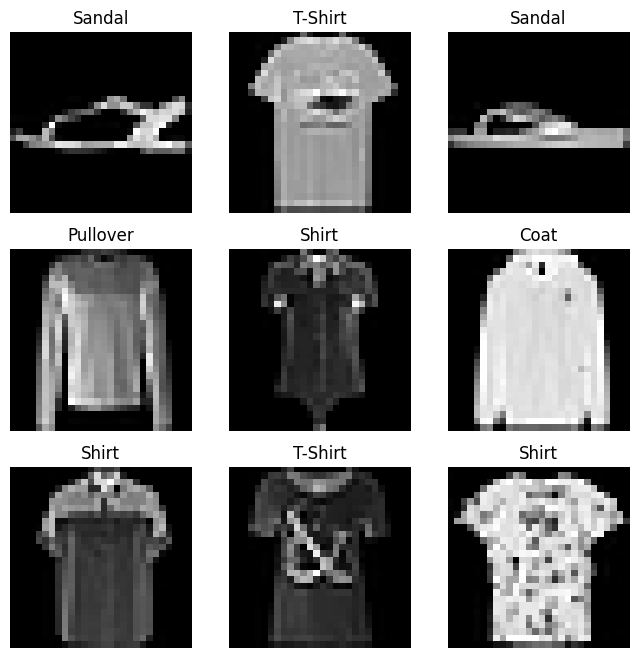

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files 为您的文件创建自定义数据集

自定义`Dataset`类必须实现三个函数： `__init__` 、 `__len__` 和 `__getitem__` 。看看这个实现； FashionMNIST 图像存储在目录`img_dir`中，它们的标签单独存储在 `CSV` 文件a`nnotations_file`中。

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### `__init__`

`__init__` 函数在实例化 `Dataset` 对象时运行一次。我们初始化包含图像、标注文件的目录和两种转换方法

labels.csv 文件如下所示

```text
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

In [5]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### `__len__`

·__len__ `函数返回数据集中的样本数。

In [6]:
def __len__(self):
    return len(self.img_labels)

### `__getitem__`

`__getitem__` 函数加载并返回给定索引`idx`处的数据集的样本。基于索引，它识别图像在磁盘上的位置，使用`read_image`将其转换为张量，从`self.img_labels`中的 `csv` 数据中检索相应的标签，调用它们的转换函数（如果适用），然后返回张量图像以及元组中相应的标签。

In [7]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

## Preparing your data for training with DataLoaders 使用 DataLoaders 准备数据以进行训练

`Dataset`检索数据集的特征并一次标记一个样本。在训练模型时，我们通常希望以“小批量”方式传递样本，在每个时期重新整理数据以减少模型过度拟合，并使用 `Python` 的`multiprocessing`来加速数据检索。

`DataLoader`是一个可迭代对象，它通过一个简单的 API 为我们抽象了这种复杂性。

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader 遍历 DataLoader

我们已将该数据集加载到`DataLoader`中，并且可以根据需要迭代数据集。下面的每次迭代都会返回一批`train_features`和`train_labels` （分别包含`batch_size=64`特征和标签）。因为我们指定了`shuffle=True` ，所以在迭代所有批次后，数据将被打乱（为了更细粒度地控制数据加载顺序，请查看[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) ）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


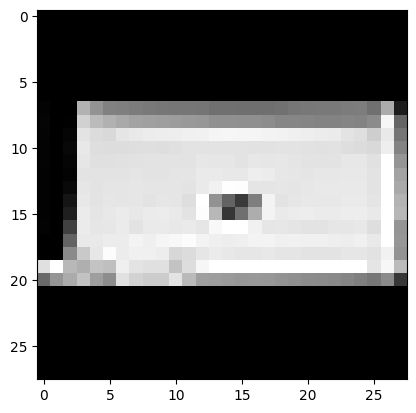

Label: 8


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")